In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.nn import Parameter
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax
import torch.optim as optim
from torch_geometric.nn.conv import feast_conv
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [42]:
# Definition of the damped sine wave functions
def damped_sine_wave(t, A, omega, phi, alpha):
    return A * np.exp(-alpha * t) * np.sin(omega * t + phi)

def damped_sine_wave_2(t, A1, omega1, phi1, alpha1, A2, omega2, phi2, alpha2):
    return A1 * np.exp(-alpha1 * t) * np.sin(omega1 * t + phi1) + A2 * np.exp(-alpha2 * t) * np.sin(omega2 * t + phi2)

In [78]:
#Time history specifics
dt = 0.01
T = 2
time = np.arange(0,T,dt)

data = []
current_group = []
with open('Data\\trussBridgeData3.txt') as f:
    for line in f:
        if line.strip():  # If the line is not empty
            row = [float(x) for x in line.split()]
            current_group.append(row)
        else:  # If the line is empty
            if current_group:
                data.append(current_group)
                current_group = []
displacement_z_data = np.array(data)

In [80]:
#Load truss data
data_set = torch.load("Data\\trussDataObjects3")
print(*data_set[120].x[4].tolist())

4.0 5100.0 0.0 0.0 0.0


2.965574026107788 75.72016906738281 -1.9942132234573364 2.7709741592407227 1.0705753564834595 130.37220764160156 -2.0520498752593994 23.75042152404785


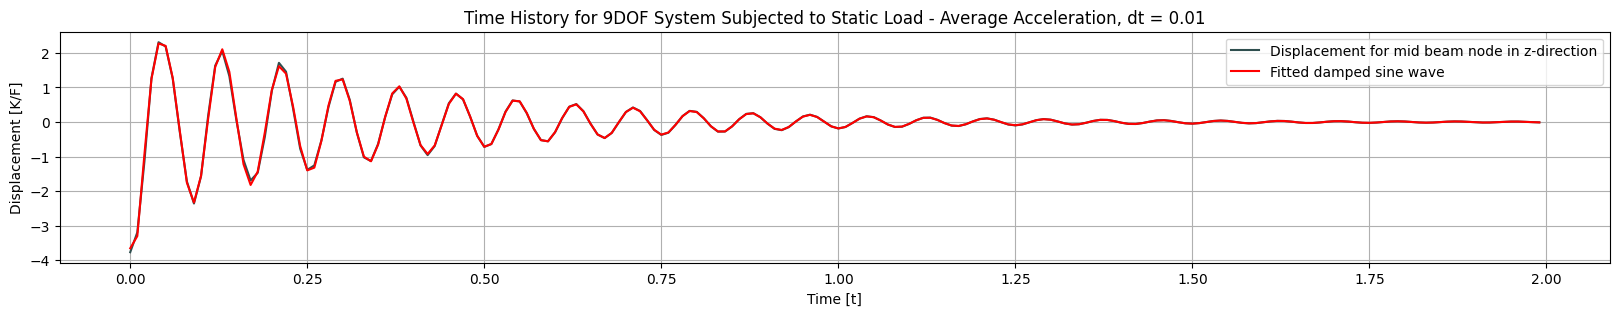

55


In [81]:
#Check an example
print(*data_set[120].y[4].tolist())
fitted = damped_sine_wave_2(time, *data_set[120].y[4].tolist())
id = data_set[120].bridge_id
original = displacement_z_data[id][4]

title = 'Time History for 9DOF System Subjected to Static Load - Average Acceleration, dt = '+str(dt)
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(3)
plt.plot(time, original, color='darkslategrey', label='Displacement for mid beam node in z-direction')
plt.plot(time, fitted, 'r-', label='Fitted damped sine wave')
#plt.scatter(time[maxAbsInd], disp[maxAbsInd], color='red', label='Max displacement = '+str(round(disp[maxAbsInd],8)))
plt.xlabel('Time [t]')
plt.ylabel('Displacement [K/F]')
plt.grid()
plt.legend()
plt.title(title)
plt.show()

print(id)

In [82]:
import datetime
versj = 1
today = datetime.date.today().strftime("%b-%d")
print(today)

May-20


In [44]:
versj =2

In [83]:
if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device('cpu')

print("Using {}.".format(device_name))

Using cpu.


In [84]:
#Creating data sets

#80 percent training data
training_data = data_set[:int(len(data_set)*0.8)]
#10 percent validation data
validation_data = data_set[int(len(data_set)*0.8):int(0.9*len(data_set))]
#10 percent test data
test_data = data_set[int(0.9*len(data_set)):]
print(len(training_data))
print(len(validation_data))
print(len(test_data))
print(training_data[0].y.shape)
print(test_data[0])

1696
212
213
torch.Size([32, 8])
Data(x=[32, 5], edge_index=[2, 136], y=[32, 8], bridge_id=575)


In [85]:
#Definition of model

class TrussGNN(torch.nn.Module):
    def __init__(self, in_channels, num_classes, heads, t_inv = True):
        super(TrussGNN, self).__init__()
        self.fc0 = nn.Linear(in_channels, 16)
        self.conv1 = feast_conv.FeaStConv(16, 32, heads=heads, t_inv=t_inv)
        self.conv2 = feast_conv.FeaStConv(32, 64, heads=heads, t_inv=t_inv)
        self.conv3 = feast_conv.FeaStConv(64, 128, heads=heads, t_inv=t_inv)
        self.conv4 = feast_conv.FeaStConv(128, 256, heads=heads, t_inv=t_inv)
        self.conv5 = feast_conv.FeaStConv(256, 512, heads=heads, t_inv=t_inv)
        self.fc1 = nn.Linear(512, 64)
        self.fc2 = nn.Linear(64, 8)

        self.reset_parameters()

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()
        self.conv3.reset_parameters()
        self.conv4.reset_parameters()
        self.conv5.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.fc0(x))
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = F.relu(self.conv5(x, edge_index))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class TrussGNN2(torch.nn.Module):
    def __init__(self, in_channels, num_classes, heads, t_inv = True):
        super(TrussGNN2, self).__init__()
        self.fc0 = nn.Linear(in_channels, 16)
        self.conv1 = feast_conv.FeaStConv(16, 32, heads=heads, t_inv=t_inv)
        self.conv2 = feast_conv.FeaStConv(32, 64, heads=heads, t_inv=t_inv)
        self.conv3 = feast_conv.FeaStConv(64, 128, heads=heads, t_inv=t_inv)
        self.conv4 = feast_conv.FeaStConv(128, 256, heads=heads, t_inv=t_inv)
        self.conv5 = feast_conv.FeaStConv(256, 512, heads=heads, t_inv=t_inv)
        self.conv6 = feast_conv.FeaStConv(512, 128, heads=heads, t_inv=t_inv)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 8)
        self.reset_parameters()

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()
        self.conv3.reset_parameters()
        self.conv4.reset_parameters()
        self.conv5.reset_parameters()
        self.conv6.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.fc0(x))
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = F.relu(self.conv5(x, edge_index))
        x = F.relu(self.conv6(x, edge_index))
        x = F.relu(self.fc1(x))
        
        x = self.fc2(x)
        return x
    
class TrussGNN3(torch.nn.Module):
    def __init__(self, in_channels, num_classes, heads, t_inv = True):
        super(TrussGNN3, self).__init__()
        self.fc0 = nn.Linear(in_channels, 16)
        self.fc1 = nn.Linear(16, 32)
        self.conv1 = feast_conv.FeaStConv(32, 64, heads=heads, t_inv=t_inv)
        self.conv2 = feast_conv.FeaStConv(64, 128, heads=heads, t_inv=t_inv)
        self.conv3 = feast_conv.FeaStConv(128, 256, heads=heads, t_inv=t_inv)
        self.conv4 = feast_conv.FeaStConv(256, 512, heads=heads, t_inv=t_inv)
        self.conv5 = feast_conv.FeaStConv(512, 1024, heads=heads, t_inv=t_inv)
        self.conv6 = feast_conv.FeaStConv(1024, 2048, heads=heads, t_inv=t_inv)
        self.conv7 = feast_conv.FeaStConv(2048, 4096, heads=heads, t_inv=t_inv)
        self.conv8 = feast_conv.FeaStConv(4096, 4096, heads=heads, t_inv=t_inv)
        self.conv9 = feast_conv.FeaStConv(4096, 2048, heads=heads, t_inv=t_inv)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 64)
        self.fc4 = nn.Linear(64, 8)

        self.reset_parameters()

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()
        self.conv3.reset_parameters()
        self.conv4.reset_parameters()
        self.conv5.reset_parameters()
        self.conv6.reset_parameters()
        self.conv7.reset_parameters()
        self.conv8.reset_parameters()
        self.conv9.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.elu(self.fc0(x))
        x = F.elu(self.fc1(x))
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = F.elu(self.conv3(x, edge_index))
        x = F.elu(self.conv4(x, edge_index))
        x = F.elu(self.conv5(x, edge_index))
        x = F.elu(self.conv6(x, edge_index))
        x = F.elu(self.conv7(x, edge_index))
        x = F.elu(self.conv8(x, edge_index))
        x = F.elu(self.conv9(x, edge_index))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = self.fc4(x)
        return x

In [86]:
import time
import torch
import torch.nn.functional as F


def print_info(info):
    message = ('Epoch: {}/{}, Duration: {:.3f}s,'
               'Train Loss: {:.4f}, Test Loss:{:.4f}').format(
                   info['current_epoch'], info['epochs'], info['t_duration'],
                   info['train_loss'], info['test_loss'])
    print(message)


def run(model, train_loader, test_loader, num_nodes, epochs, optimizer, device):
    train_losses = []
    test_losses = []
    for epoch in range(1, epochs + 1):
        t = time.time()
        train_loss = train(model, train_loader, optimizer, device)
        t_duration = time.time() - t
        test_loss = test(model, test_loader, num_nodes, device)
        eval_info = {
            'train_loss': train_loss,
            'test_loss': test_loss,
            'current_epoch': epoch,
            'epochs': epochs,
            't_duration': t_duration
        }

        print_info(eval_info)
        test_losses.append(test_loss)
        train_losses.append(train_loss)
    return train_losses, test_losses


def train(model, train_loader, optimizer, device):
    model.train()

    total_loss = 0
    for idx, data in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data.to(device))
        # Calculate MSE loss for each item in output and labels
        losses = F.l1_loss(output, data.y.to(device))#, reduction='none')  
        # Compute mean loss for backpropagation
        loss = losses.mean()  
        loss.backward(retain_graph=True)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)


def test(model, test_loader, num_nodes, device):
    model.eval()
    correct = 0
    total_loss = 0
    n_graphs = 0
    with torch.no_grad():
        for idx, data in enumerate(test_loader):
            out = model(data.to(device))
            total_loss += F.l1_loss(out, data.y.to(device)).item()
    return total_loss / len(test_loader)

In [87]:
#runner
num_nodes = training_data[0].x.shape[0]
num_features = training_data[0].x.shape[1]

model3 = TrussGNN(num_features, num_nodes, heads=8).to(device_name)

optimizer = optim.Adam(model3.parameters(),
                       lr=0.0001)


train_losses, test_losses = \
run(model3, training_data, validation_data, num_nodes, 100, optimizer, device_name)

#versj defined at the top of the notebook
modelPath = "trained_models\\" + today + "TrussGNN_VS" + str(versj) +".pt"
trainLossPath = "trained_models\\" + today + "TrussGNN_VS_" + str(versj) + "TrainLoss.txt"
testLossPath = "trained_models\\" + today + "TrussGNN_VS_" + str(versj) + "TestLoss.txt"
np.savetxt(trainLossPath, np.array(train_losses))
np.savetxt(testLossPath, np.array(test_losses))
torch.save(model3.state_dict(), modelPath)
versj += 1
print("saved as: ", modelPath)

Epoch: 1/100, Duration: 132.987s,Train Loss: 811.8722, Test Loss:872.8177
Epoch: 2/100, Duration: 151.449s,Train Loss: 809.8690, Test Loss:872.9695
Epoch: 3/100, Duration: 137.247s,Train Loss: 808.6845, Test Loss:872.1667
Epoch: 4/100, Duration: 139.300s,Train Loss: 809.0066, Test Loss:872.2663
Epoch: 5/100, Duration: 139.648s,Train Loss: 808.1347, Test Loss:872.5402
Epoch: 6/100, Duration: 123.480s,Train Loss: 808.6569, Test Loss:872.1499
Epoch: 7/100, Duration: 125.711s,Train Loss: 808.9478, Test Loss:872.7379
Epoch: 8/100, Duration: 125.072s,Train Loss: 808.0425, Test Loss:870.8089
Epoch: 9/100, Duration: 117.844s,Train Loss: 807.2967, Test Loss:870.5105
Epoch: 10/100, Duration: 125.120s,Train Loss: 807.4449, Test Loss:871.2289
Epoch: 11/100, Duration: 142.547s,Train Loss: 806.5920, Test Loss:869.9012
Epoch: 12/100, Duration: 156.533s,Train Loss: 806.1059, Test Loss:869.5040
Epoch: 13/100, Duration: 146.850s,Train Loss: 806.4699, Test Loss:869.6537
Epoch: 14/100, Duration: 147.271s,

KeyboardInterrupt: 

In [61]:
#runner
num_nodes = training_data[0].x.shape[0]
num_features = training_data[0].x.shape[1]

model4 = TrussGNN2(num_features, num_nodes, heads=8).to(device_name)

optimizer = optim.Adam(model4.parameters(),
                       lr=0.0001)


train_losses, test_losses = \
run(model4, training_data, validation_data, num_nodes, 500, optimizer, device_name)

#versj defined at the top of the notebook
modelPath = "trained_models\\" + today + "TrussGNNVersion" + str(versj) +".pt"
trainLossPath = "trained_models\\" + today + "TrussGNNVersion" + str(versj) + "TrainLoss.txt"
testLossPath = "trained_models\\" + today + "TrussGNNVersion" + str(versj) + "TestLoss.txt"
np.savetxt(trainLossPath, np.array(train_losses))
np.savetxt(testLossPath, np.array(test_losses))
torch.save(model4.state_dict(), modelPath)
versj += 1
print("saved as: ", modelPath)

Epoch: 1/500, Duration: 235.142s,Train Loss: 843.4124, Test Loss:841.0558
Epoch: 2/500, Duration: 236.435s,Train Loss: 841.7259, Test Loss:840.6511
Epoch: 3/500, Duration: 254.464s,Train Loss: 841.5381, Test Loss:840.2729
Epoch: 4/500, Duration: 242.520s,Train Loss: 841.3600, Test Loss:840.0001
Epoch: 5/500, Duration: 226.832s,Train Loss: 841.2952, Test Loss:840.3561
Epoch: 6/500, Duration: 224.211s,Train Loss: 841.2526, Test Loss:840.5797
Epoch: 7/500, Duration: 215.833s,Train Loss: 841.0099, Test Loss:839.8701
Epoch: 8/500, Duration: 223.123s,Train Loss: 840.5806, Test Loss:840.6559
Epoch: 9/500, Duration: 238.456s,Train Loss: 840.3984, Test Loss:839.2738
Epoch: 10/500, Duration: 232.064s,Train Loss: 839.8640, Test Loss:838.9739
Epoch: 11/500, Duration: 229.032s,Train Loss: 839.6081, Test Loss:837.9431
Epoch: 12/500, Duration: 236.366s,Train Loss: 838.9668, Test Loss:838.3096
Epoch: 13/500, Duration: 229.528s,Train Loss: 839.3363, Test Loss:837.6551
Epoch: 14/500, Duration: 222.203s,

KeyboardInterrupt: 

In [62]:
model_dict = torch.load("trained_modelsMay-19TrussGNNVersion1.pt")
model3.load_state_dict(model_dict)
model3.eval()
print(*test_data[0].y[26].tolist())

print(model3(test_data[0])[26])
labels = test_data[0].y[26].tolist()
print(*labels)


3.4969401359558105 84.56969451904297 -2.070795774459839 3.380460023880005 2.8007428646087646 127.6114501953125 -1.8838518857955933 36.595909118652344
tensor([   3.1698,   85.4655,   -1.9465,    3.5888,    2.5523, -116.0046,
          -1.1088,   34.6657], grad_fn=<SelectBackward0>)
3.4969401359558105 84.56969451904297 -2.070795774459839 3.380460023880005 2.8007428646087646 127.6114501953125 -1.8838518857955933 36.595909118652344


In [73]:
print(len(test_data[0].x))

32


56


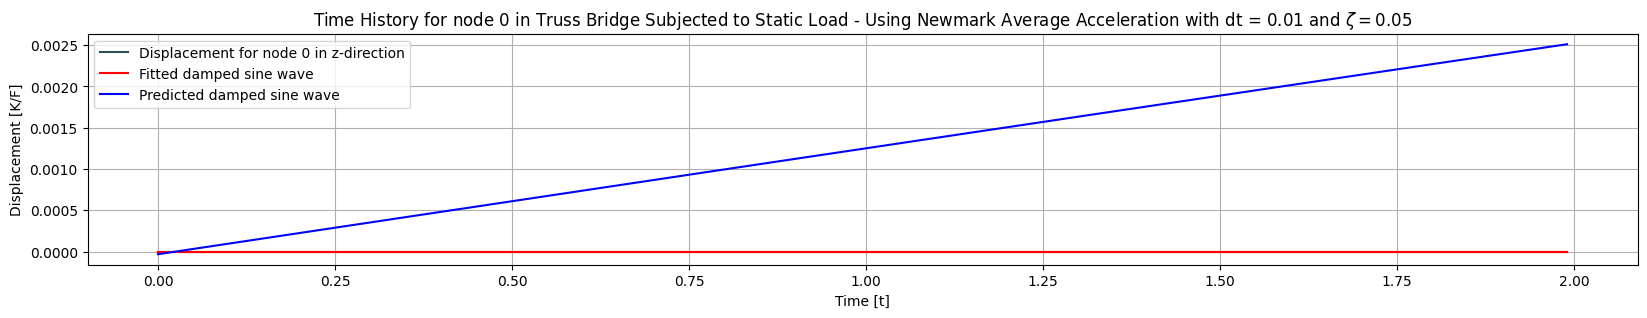

[0.026696503162384033, 0.07054531574249268, -0.002050023525953293, 0.003049701452255249, -0.014799609780311584, 0.04038196802139282, -0.001546856015920639, 0.0078553706407547]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
56


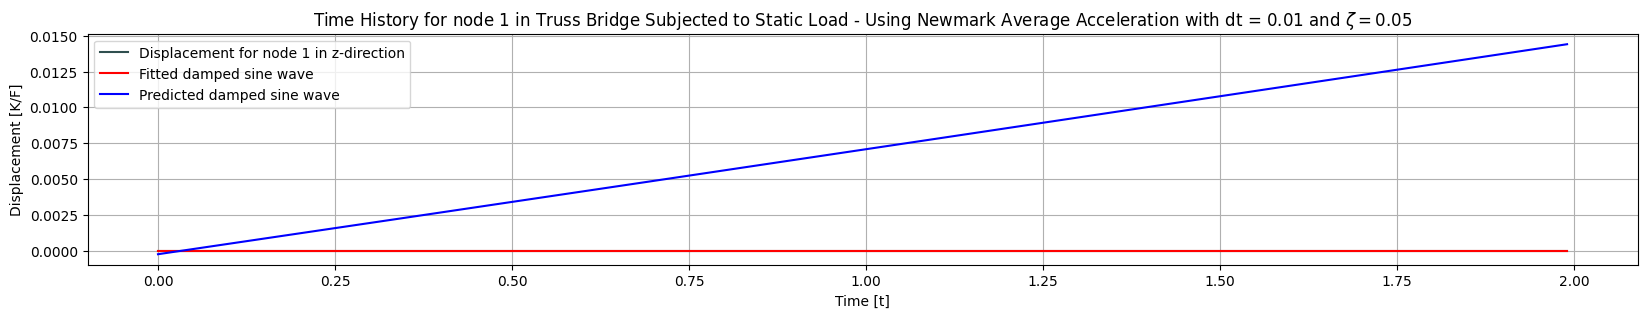

[-0.04243767261505127, -0.11305594444274902, 0.0035343877971172333, -0.007613249123096466, -0.0260087251663208, -0.09464061260223389, 0.003453146666288376, -0.01634882390499115]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
56


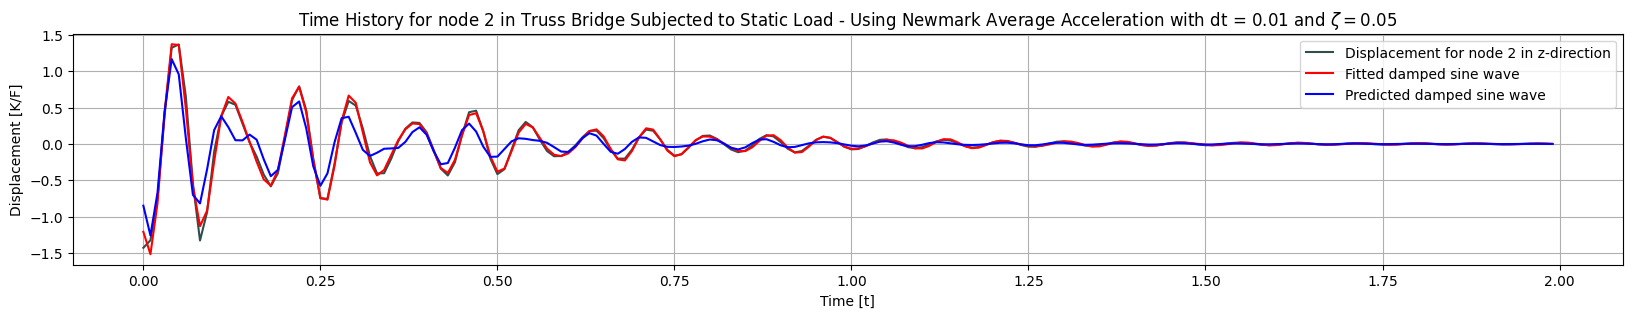

[0.696718692779541, 75.3801040649414, -1.8254916667938232, 2.9997482299804688, 0.7179500460624695, 105.78872680664062, -2.895449638366699, 4.0985188484191895]
[1.1982158422470093, 75.10787200927734, -1.894105315208435, 2.693115234375, 0.5086509585380554, 103.48892974853516, -2.9987478256225586, 3.1840333938598633]
56


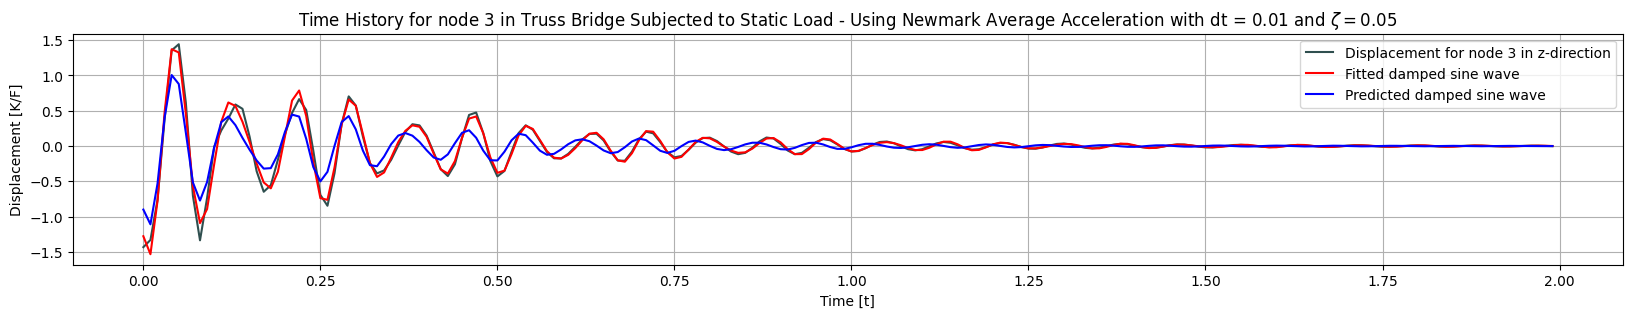

[0.8014452457427979, 76.73828887939453, -1.8966721296310425, 3.0508880615234375, 0.4345247149467468, 103.85183715820312, -2.810195207595825, 4.582188129425049]
[1.2101629972457886, 75.15276336669922, -1.91097891330719, 2.685727596282959, 0.4836919605731964, 102.9709701538086, -2.852874517440796, 3.205411434173584]
56


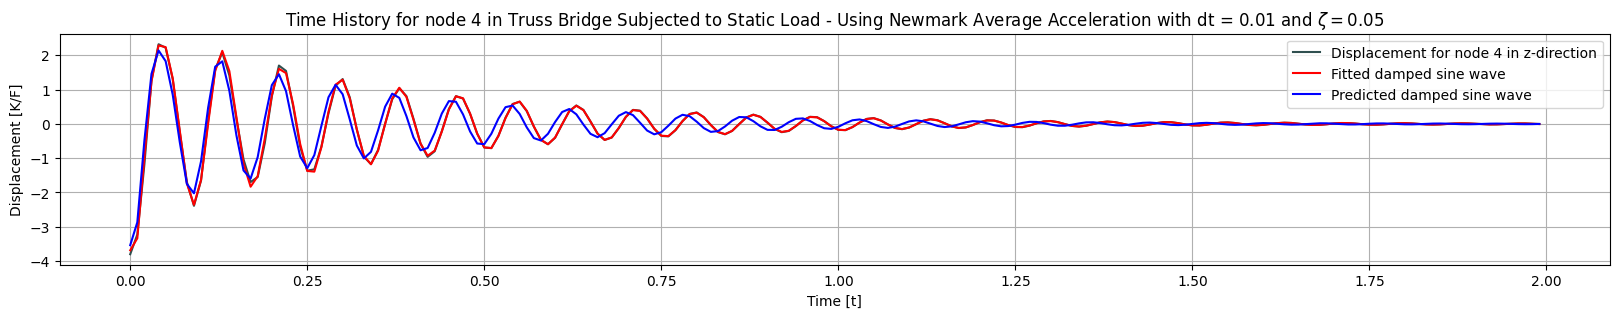

[2.6855759620666504, 76.6646499633789, -1.897472620010376, 2.931427001953125, 1.0721122026443481, 130.53460693359375, -1.951096773147583, 23.09307289123535]
[2.997796058654785, 75.35221099853516, -1.9918794631958008, 2.744424819946289, 1.0762889385223389, 130.03550720214844, -2.0540823936462402, 23.722471237182617]
56


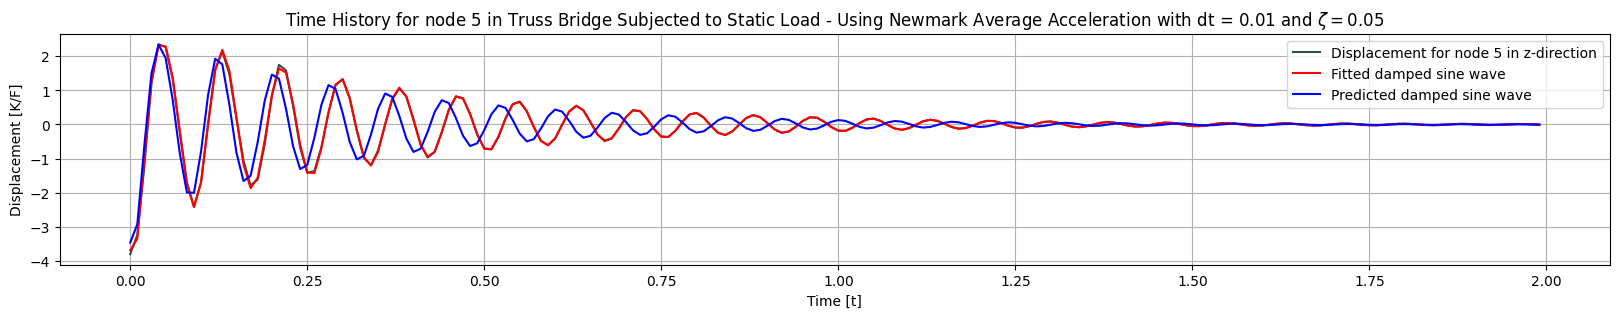

[2.8712732791900635, 78.72116088867188, -1.9272828102111816, 3.0766093730926514, 0.8303758502006531, 130.167724609375, -1.9426109790802002, 21.618236541748047]
[3.0654757022857666, 75.37026977539062, -1.99947190284729, 2.738109588623047, 0.9970314502716064, 129.42515563964844, -2.0104897022247314, 21.5152645111084]
56


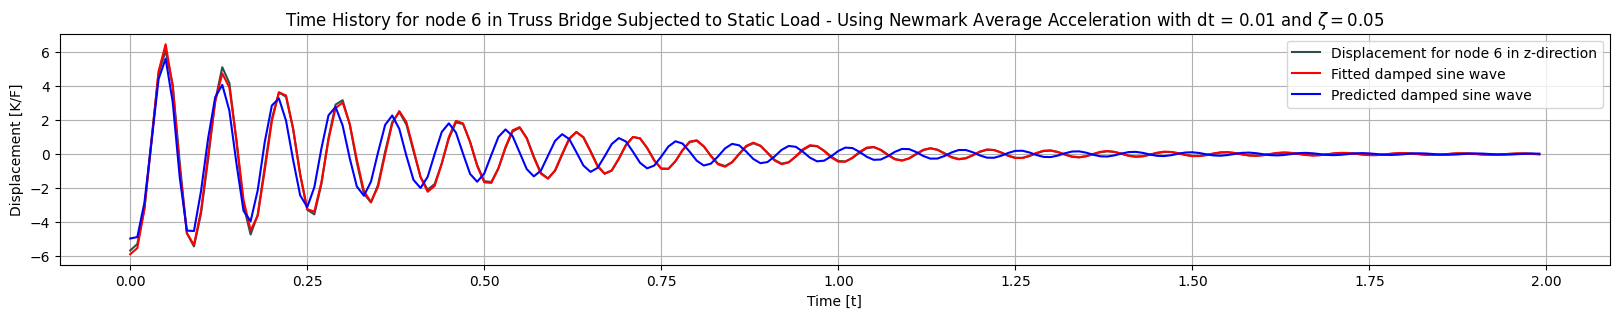

[6.033042907714844, 77.94855499267578, -2.0897796154022217, 2.683093547821045, -0.8840253949165344, 139.24557495117188, -2.8218231201171875, 8.948135375976562]
[6.894515514373779, 75.45774841308594, -2.036663055419922, 2.6457786560058594, -1.0100244283676147, 138.83856201171875, -2.8641018867492676, 9.92607307434082]
56


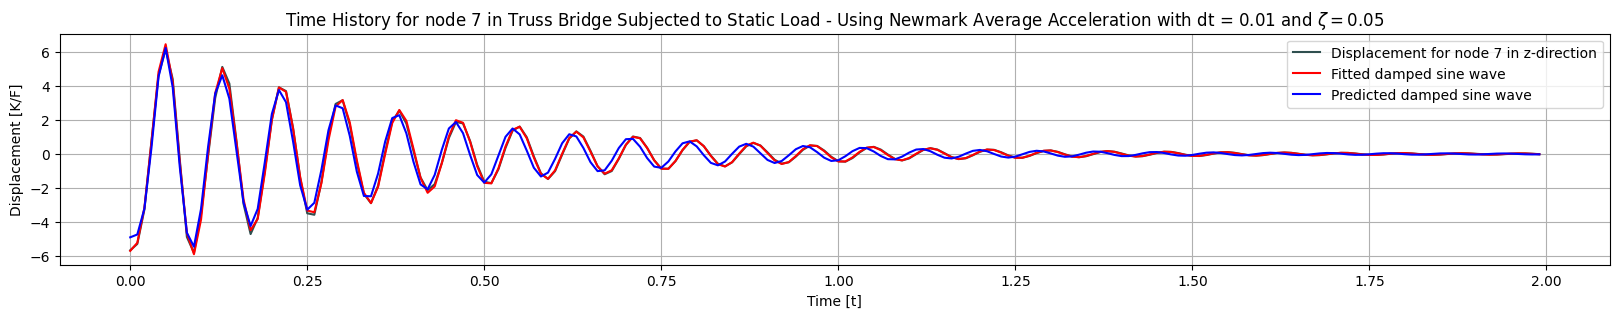

[6.831734657287598, 76.36732482910156, -2.065261125564575, 2.798572063446045, -2.137253999710083, 126.70232391357422, -2.596332311630249, 22.051963806152344]
[7.301761627197266, 75.46302795410156, -2.0375640392303467, 2.7212882041931152, -2.037201166152954, 123.35643005371094, -2.728196382522583, 24.796550750732422]
56


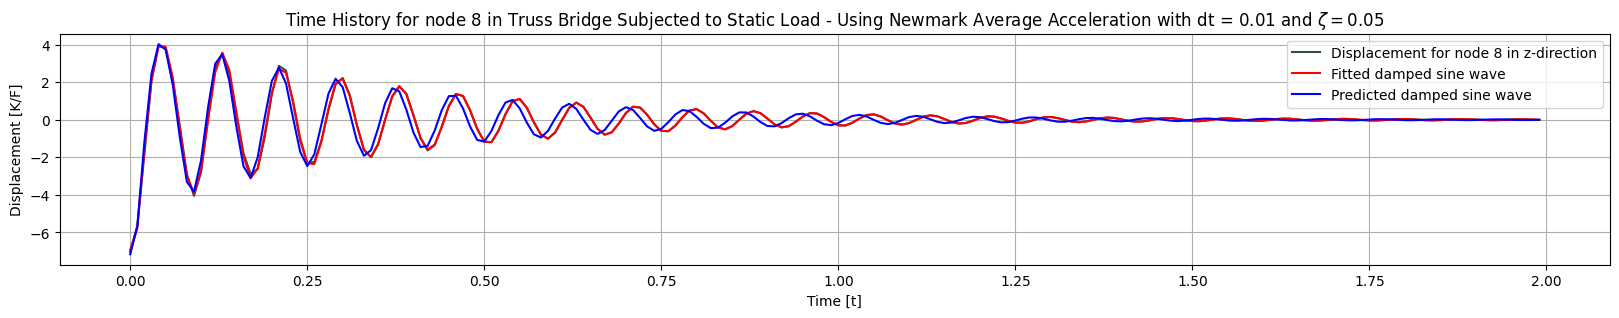

[5.091357231140137, 76.69001007080078, -1.9615683555603027, 2.8889822959899902, 2.585256338119507, 127.0348892211914, -1.8895233869552612, 33.322303771972656]
[5.0469207763671875, 75.3732681274414, -2.0006465911865234, 2.72259783744812, 2.498605251312256, 124.74073791503906, -1.927148461341858, 33.00483322143555]
56


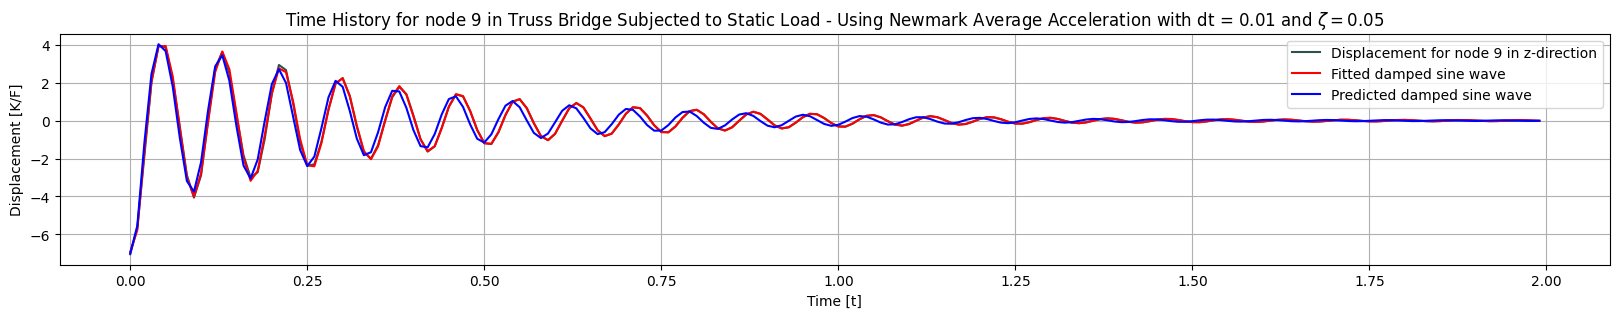

[5.0228376388549805, 76.386474609375, -1.9500041007995605, 2.925614833831787, 2.430290937423706, 123.36531829833984, -1.8447589874267578, 30.930227279663086]
[5.140305042266846, 75.39875030517578, -2.0110907554626465, 2.72367000579834, 2.377037286758423, 124.097900390625, -1.8597912788391113, 30.965015411376953]
56


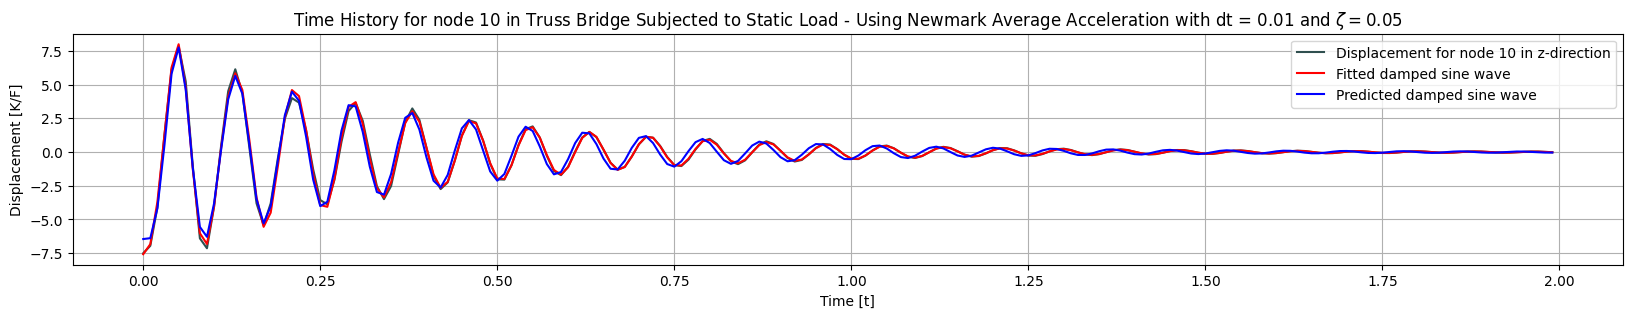

[8.200255393981934, 76.22061157226562, -2.076542854309082, 2.6949474811553955, -1.593239665031433, 137.6707763671875, -2.671311140060425, 13.98138427734375]
[8.766462326049805, 75.34920501708984, -1.9854038953781128, 2.8009777069091797, -1.36978280544281, 135.222900390625, -2.8099124431610107, 11.8001127243042]
56


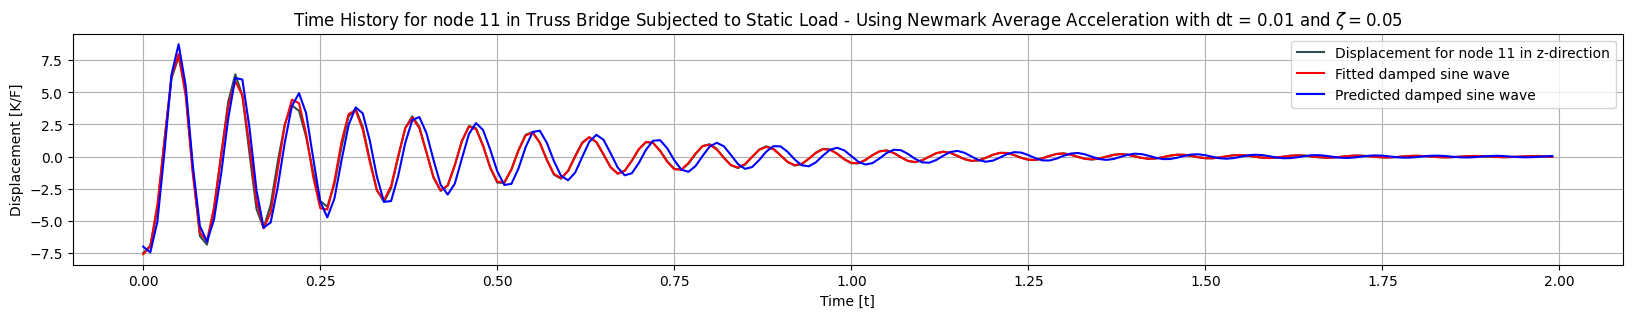

[8.964591979980469, 74.25249481201172, -2.059206485748291, 2.6122488975524902, -1.2829941511154175, 138.32504272460938, -2.3612372875213623, 6.580722332000732]
[8.661375999450684, 75.36904907226562, -1.9941779375076294, 2.766852855682373, -1.0862551927566528, 139.49180603027344, -2.8676583766937256, 8.093320846557617]
56


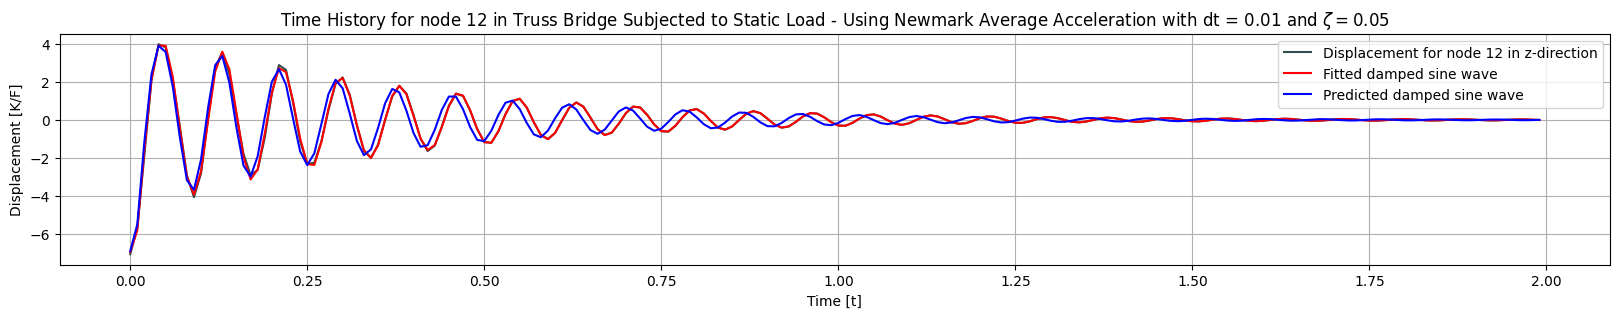

[4.874946594238281, 76.73194122314453, -1.9623305797576904, 2.8757071495056152, 2.5059239864349365, 126.14704132080078, -1.894289493560791, 32.52754211425781]
[5.046920299530029, 75.3732681274414, -2.0006465911865234, 2.72259783744812, 2.498605251312256, 124.74073791503906, -1.927148461341858, 33.00483322143555]
56


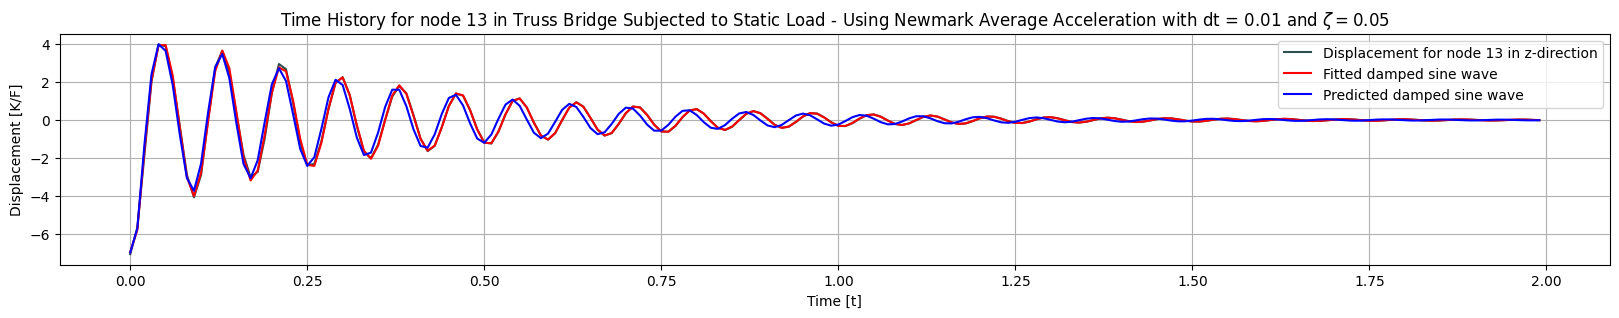

[4.940186500549316, 76.42911529541016, -1.9880088567733765, 2.8261029720306396, 2.5653445720672607, 122.28711700439453, -1.8889596462249756, 29.664213180541992]
[5.140305042266846, 75.39875030517578, -2.0110907554626465, 2.72367000579834, 2.377037286758423, 124.097900390625, -1.8597912788391113, 30.965015411376953]
56


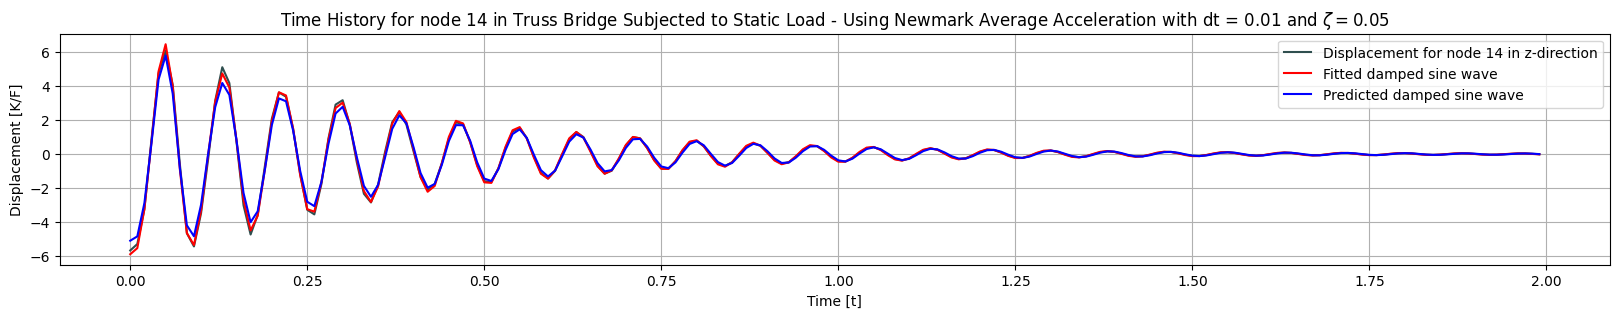

[6.144006729125977, 75.22833251953125, -2.01652193069458, 2.6132009029388428, -1.0011638402938843, 135.08782958984375, -2.6692123413085938, 10.739373207092285]
[6.894515514373779, 75.45774841308594, -2.036663055419922, 2.6457786560058594, -1.0100244283676147, 138.83856201171875, -2.8641018867492676, 9.92607307434082]
56


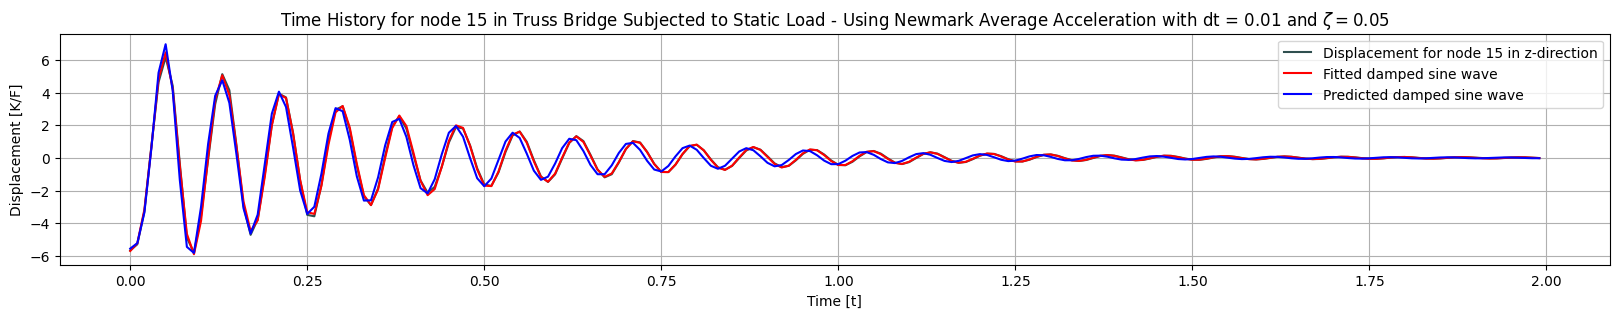

[7.412566184997559, 76.18162536621094, -1.9994486570358276, 2.896148443222046, -1.9462980031967163, 129.0654754638672, -2.4865128993988037, 13.570793151855469]
[7.301761627197266, 75.46302795410156, -2.0375640392303467, 2.7212882041931152, -2.037201166152954, 123.35643005371094, -2.728196382522583, 24.796550750732422]
56


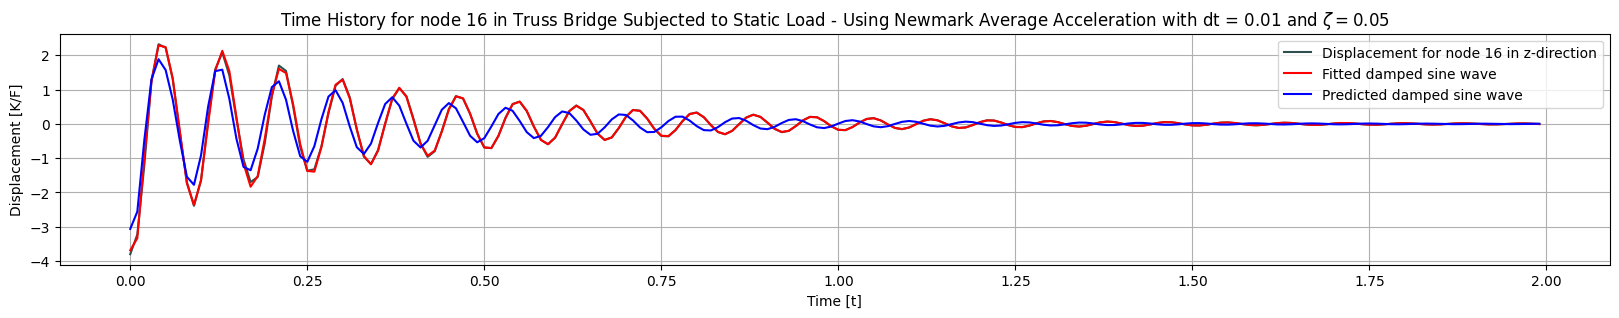

[2.382319450378418, 77.40575408935547, -1.924882173538208, 3.0274641513824463, 0.900791347026825, 131.15113830566406, -1.9668017625808716, 19.767454147338867]
[2.997796058654785, 75.35221099853516, -1.9918794631958008, 2.744424819946289, 1.0762889385223389, 130.03550720214844, -2.0540823936462402, 23.722469329833984]
56


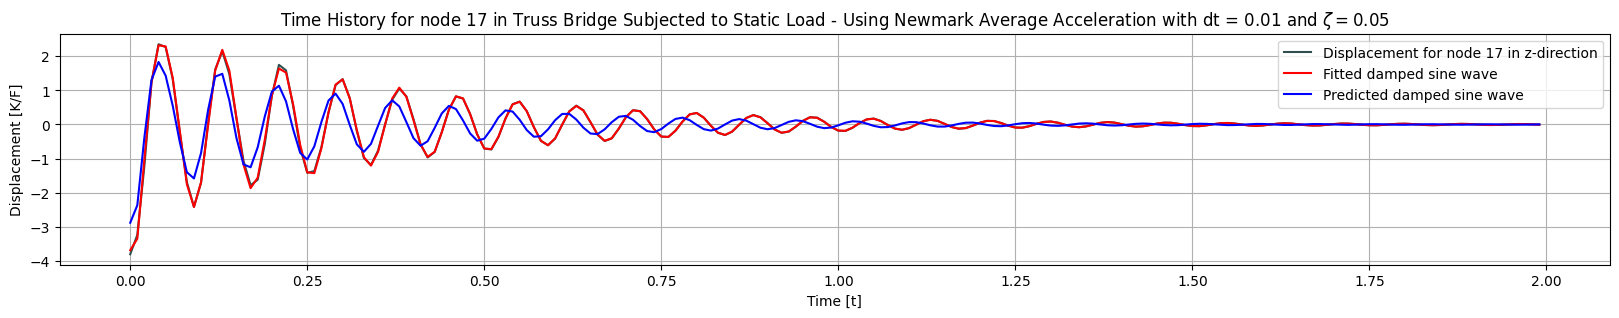

[2.2070090770721436, 77.04129028320312, -1.878361701965332, 3.062702178955078, 0.850014865398407, 127.13346099853516, -1.9767125844955444, 19.24952507019043]
[3.0654757022857666, 75.37026977539062, -1.99947190284729, 2.738109588623047, 0.9970313906669617, 129.42515563964844, -2.0104897022247314, 21.5152645111084]
56


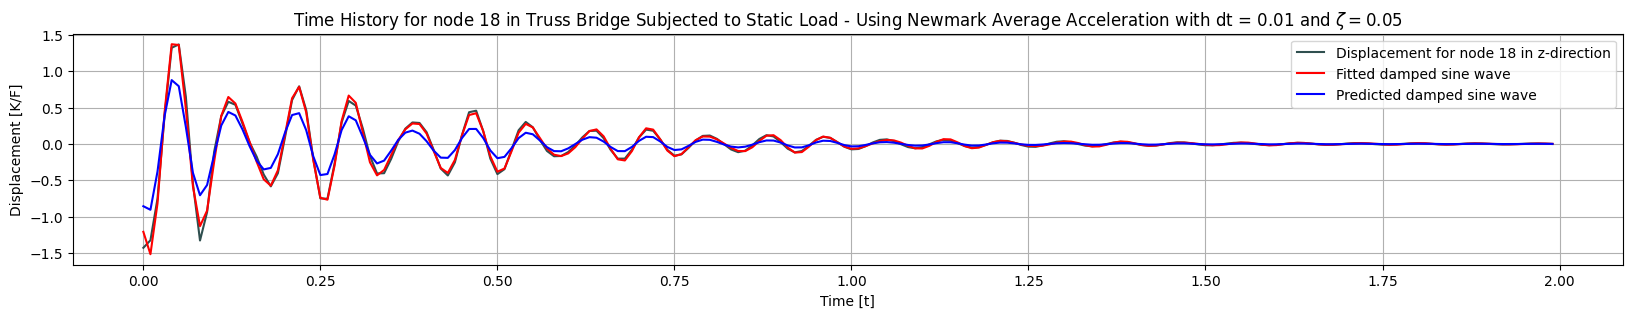

[0.8014988899230957, 75.05210876464844, -1.7767738103866577, 3.1105124950408936, 0.25897902250289917, 102.7638931274414, -2.8600962162017822, 3.75089955329895]
[1.1982158422470093, 75.10787200927734, -1.894105315208435, 2.693115234375, 0.5086509585380554, 103.48892974853516, -2.9987478256225586, 3.184033155441284]
56


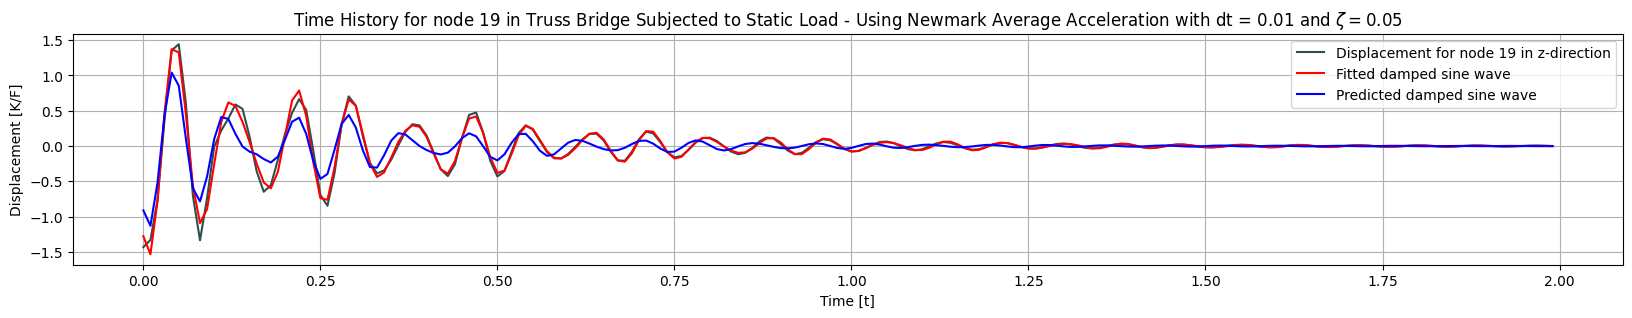

[0.7073500156402588, 76.56163024902344, -1.848458170890808, 3.0871825218200684, 0.5515062212944031, 102.14265441894531, -2.707202672958374, 4.352210998535156]
[1.2101629972457886, 75.15276336669922, -1.91097891330719, 2.685727596282959, 0.4836919605731964, 102.9709701538086, -2.852874517440796, 3.205411434173584]
56


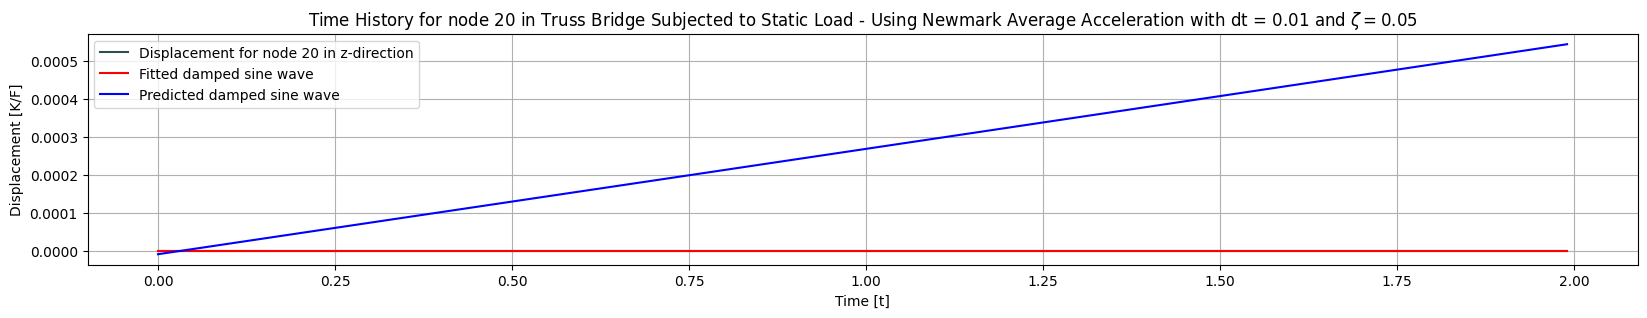

[-0.0012189149856567383, -0.0035903453826904297, 0.00020488351583480835, -0.0012558475136756897, -0.01932568848133087, -0.014138221740722656, 0.0004720762372016907, -0.0019179433584213257]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
56


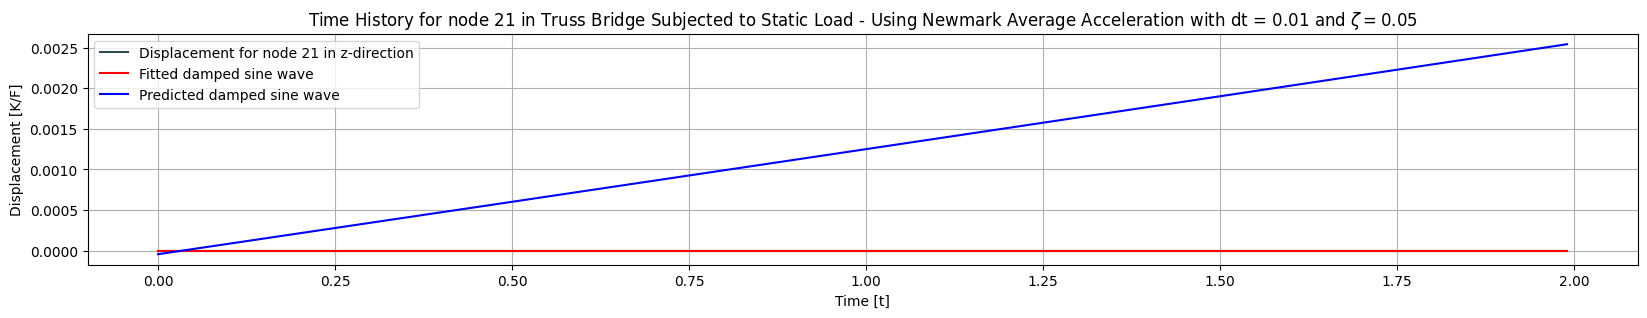

[-0.013389825820922852, -0.03591275215148926, 0.0011880025267601013, -0.003133028745651245, -0.02129901945590973, -0.03790855407714844, 0.0013523101806640625, -0.006179019808769226]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
56


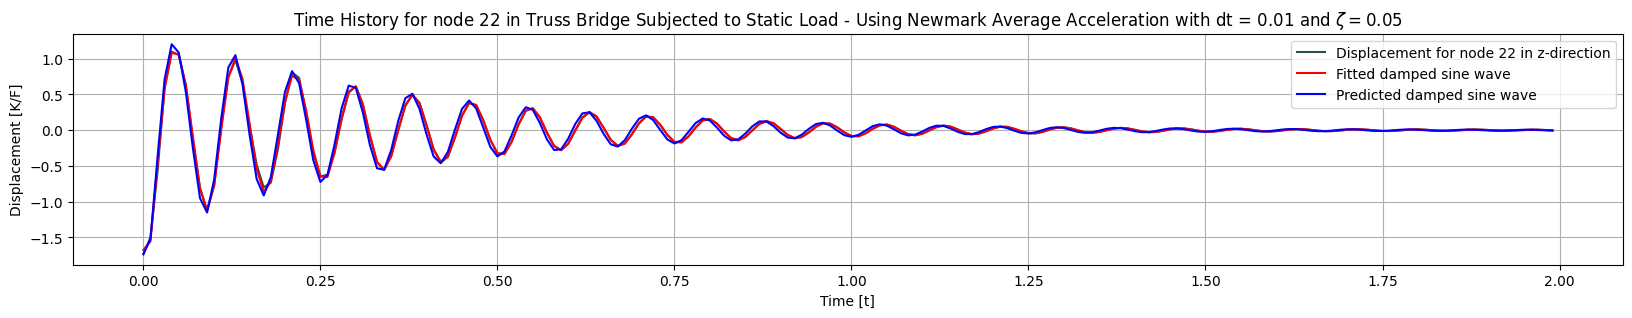

[1.4846396446228027, 75.72650146484375, -1.8895761966705322, 2.7703614234924316, 0.37535399198532104, 131.48597717285156, -2.091679334640503, 19.35881233215332]
[1.4165440797805786, 75.34151458740234, -1.9875869750976562, 2.7491674423217773, 0.4415709376335144, 131.67787170410156, -2.110365390777588, 21.194292068481445]
56


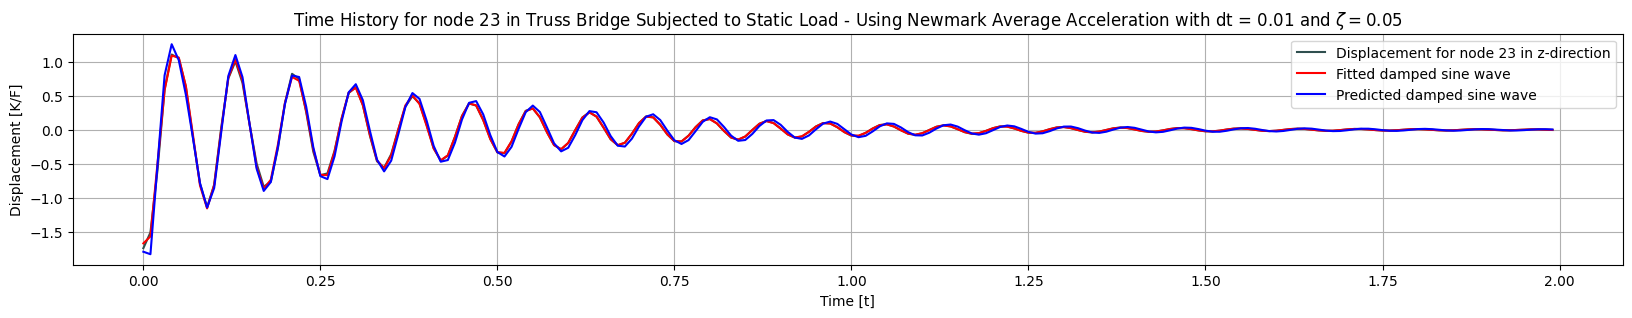

[1.4550025463104248, 74.86163330078125, -1.9350364208221436, 2.5605123043060303, 0.6754199862480164, 131.1112060546875, -2.451915979385376, 18.314207077026367]
[1.4405888319015503, 75.35665893554688, -1.9940365552902222, 2.746666669845581, 0.4072059392929077, 132.11297607421875, -2.091373920440674, 17.149097442626953]
56


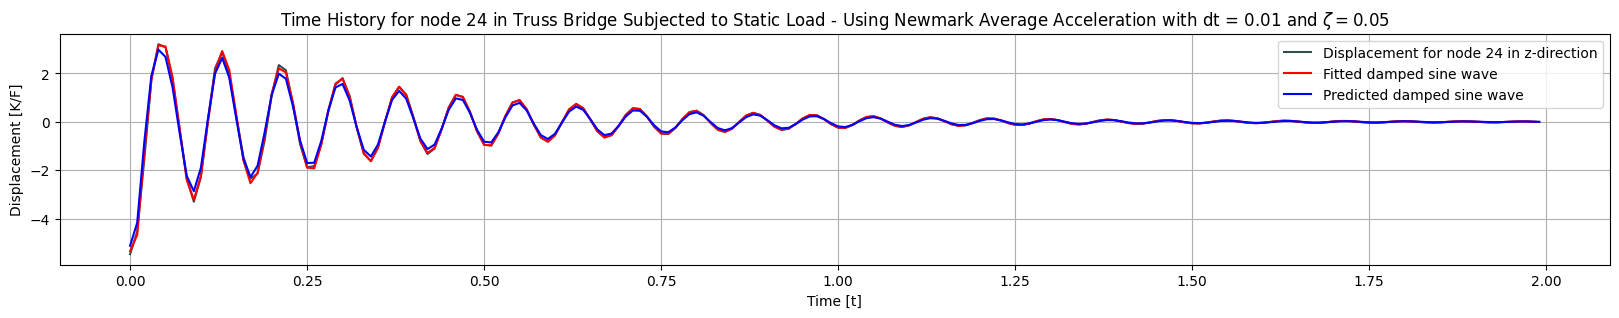

[3.727708578109741, 75.17037200927734, -1.9146168231964111, 2.8124823570251465, 1.7249871492385864, 126.25916290283203, -1.9484729766845703, 26.149616241455078]
[4.11896276473999, 75.36248016357422, -1.9961044788360596, 2.7342963218688965, 1.7458351850509644, 127.75225830078125, -1.9976340532302856, 27.7934627532959]
56


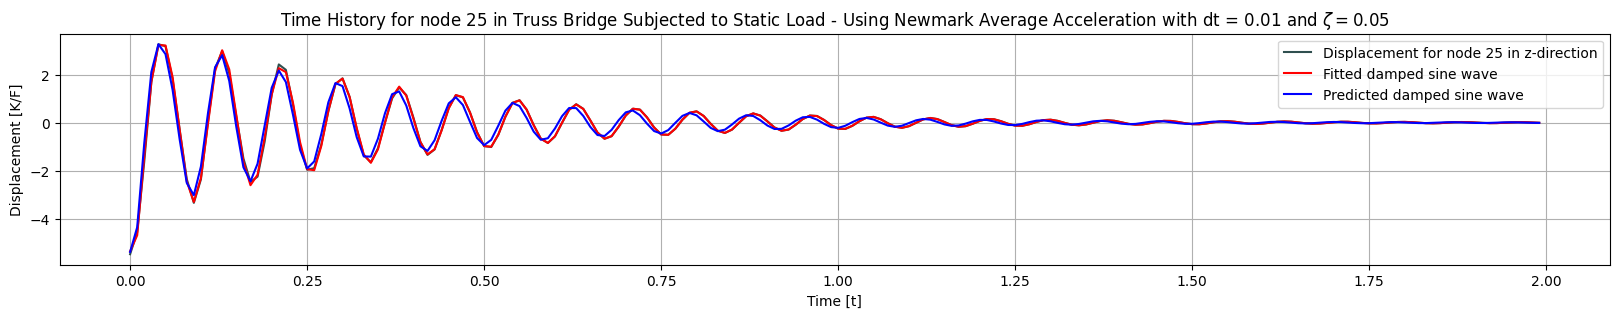

[4.020338535308838, 75.88627624511719, -1.9035862684249878, 2.9072792530059814, 1.669427514076233, 125.45112609863281, -1.9080142974853516, 24.799070358276367]
[4.225032806396484, 75.38331604003906, -2.00480580329895, 2.7279043197631836, 1.6251307725906372, 126.27384948730469, -1.936449408531189, 26.347850799560547]
56


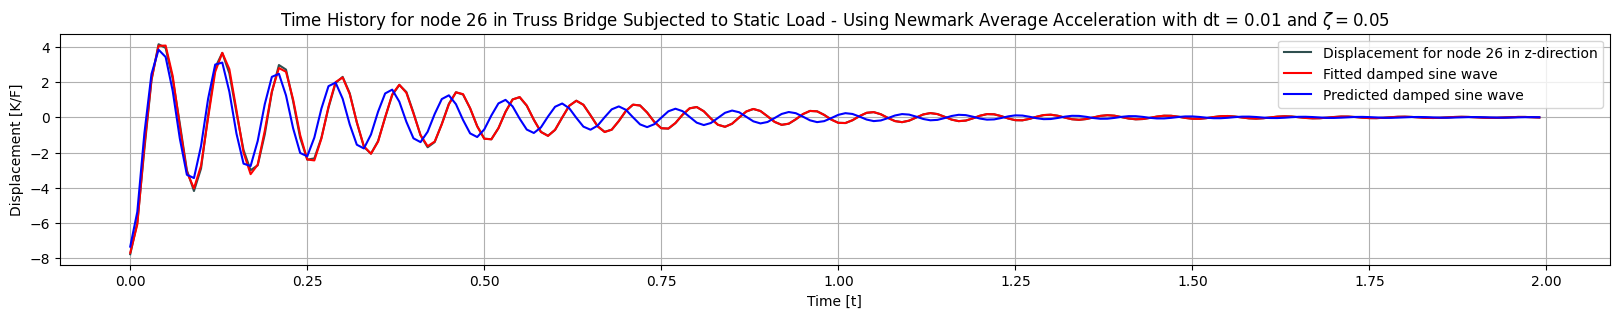

[4.776453971862793, 77.9871597290039, -1.97271728515625, 2.9480936527252197, 3.0302627086639404, 123.7094497680664, -1.7805792093276978, 38.31257629394531]
[5.209155082702637, 75.38002014160156, -2.0038068294525146, 2.7052836418151855, 3.118114948272705, 120.793212890625, -1.8627007007598877, 39.3113899230957]
56


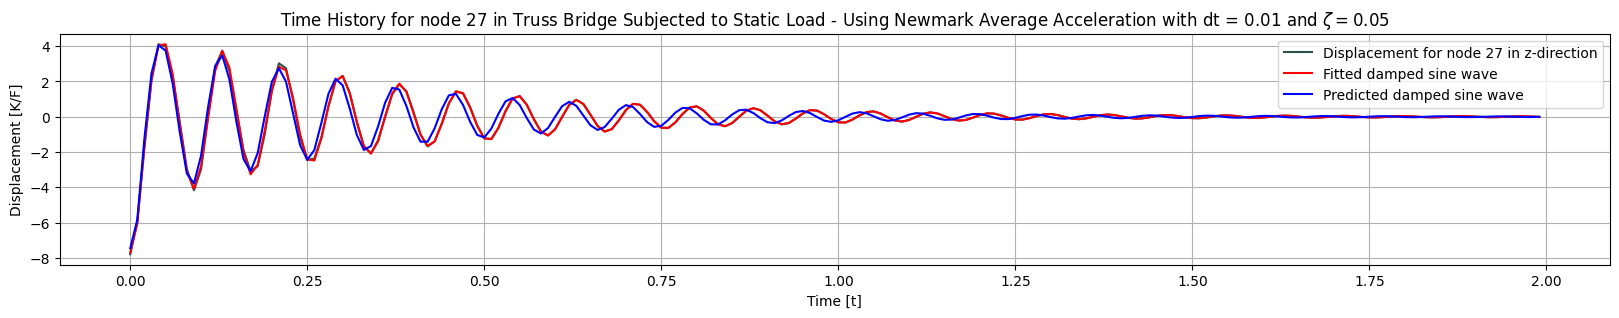

[5.045863151550293, 76.5858154296875, -1.976094126701355, 2.8793206214904785, 2.9623801708221436, 122.9457015991211, -1.8759945631027222, 35.632408142089844]
[5.2725019454956055, 75.40913391113281, -2.015667676925659, 2.7098429203033447, 3.0304336547851562, 121.22173309326172, -1.8028680086135864, 37.429019927978516]
56


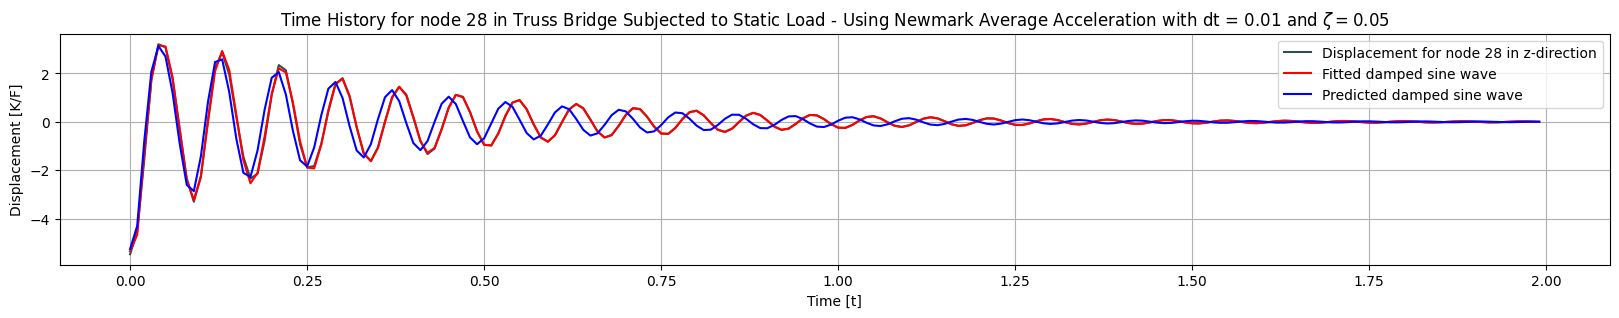

[3.882354736328125, 77.57225036621094, -1.9406704902648926, 2.928621768951416, 1.7656036615371704, 129.37307739257812, -1.9687899351119995, 27.56807518005371]
[4.11896276473999, 75.36248016357422, -1.9961044788360596, 2.7342963218688965, 1.7458351850509644, 127.75225830078125, -1.9976340532302856, 27.7934627532959]
56


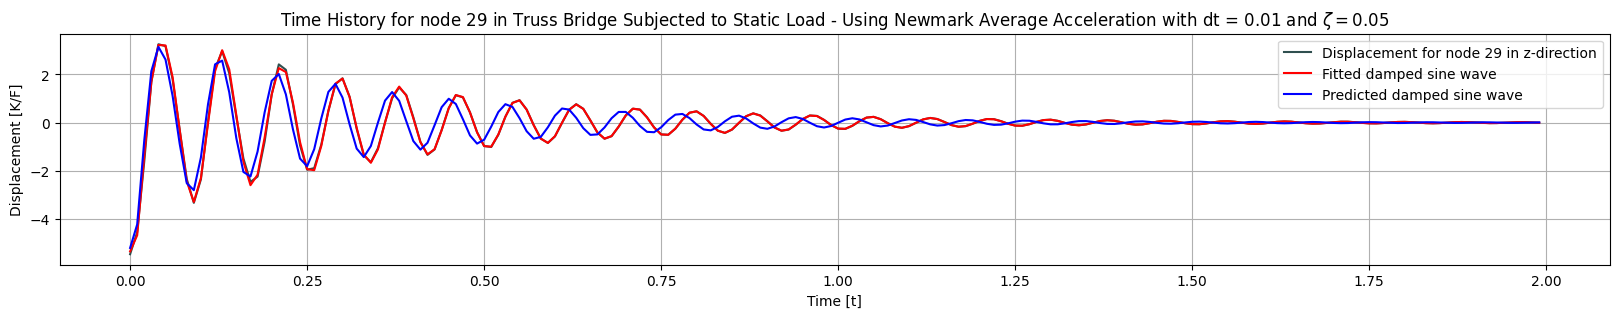

[3.8589041233062744, 77.29241943359375, -1.920599341392517, 3.0023162364959717, 1.6953245401382446, 127.13755798339844, -1.9354195594787598, 24.733457565307617]
[4.225032806396484, 75.38331604003906, -2.00480580329895, 2.7279043197631836, 1.6251307725906372, 126.27384948730469, -1.936449408531189, 26.34785270690918]
56


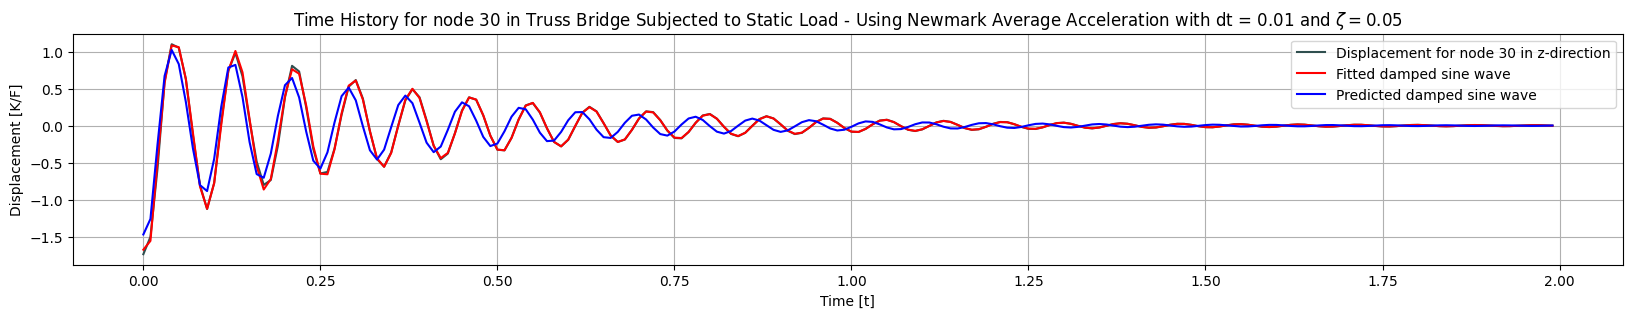

[1.21677565574646, 77.02239990234375, -1.8699207305908203, 2.9619364738464355, 0.3508560061454773, 129.09512329101562, -2.0810108184814453, 18.559871673583984]
[1.4165440797805786, 75.34151458740234, -1.9875869750976562, 2.7491674423217773, 0.4415709376335144, 131.67787170410156, -2.110365390777588, 21.194290161132812]
56


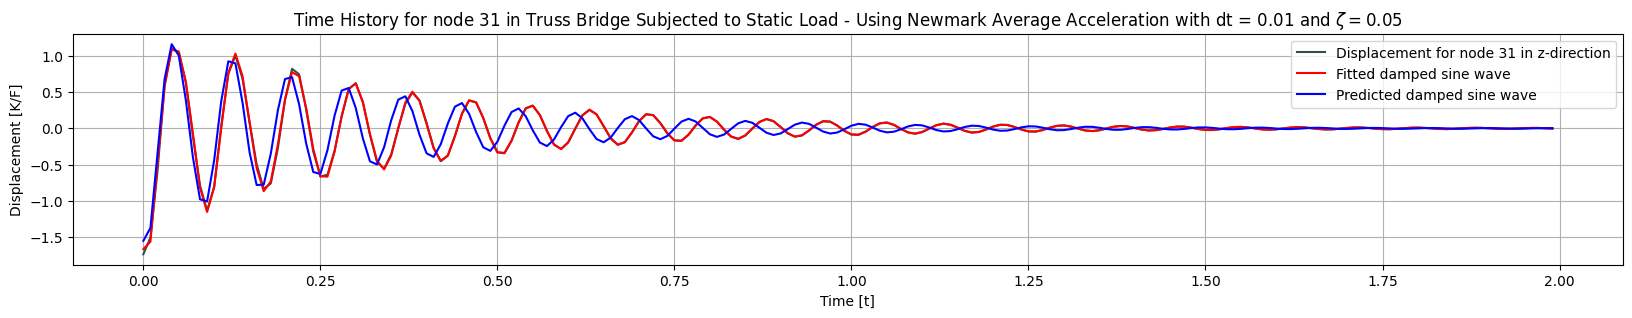

[1.4146883487701416, 77.90460205078125, -1.9015374183654785, 3.0734591484069824, 0.24316613376140594, 132.19741821289062, -2.060244560241699, 17.46965789794922]
[1.4405888319015503, 75.35665893554688, -1.9940365552902222, 2.746666669845581, 0.4072059392929077, 132.11297607421875, -2.091373920440674, 17.149097442626953]


In [77]:
dt = 0.01
T = 2
time = np.arange(0,T,dt)
bridgenr = 8

for nodenr in range(0, len(test_data[bridgenr].x)):
    labels = test_data[bridgenr].y[nodenr].tolist()
    predicted_params = model3(test_data[bridgenr])[nodenr].tolist()

    fitted = damped_sine_wave_2(time, *labels)
    id = test_data[bridgenr].bridge_id
    print(id)
    original = displacement_z_data[id][nodenr]
    prediction_fitted = damped_sine_wave_2(time, *predicted_params)


    title = 'Time History for node ' + str(nodenr) + ' in Truss Bridge Subjected to Static Load - Using Newmark Average Acceleration with dt = '\
        +str(dt) + r' and $\zeta = 0.05$'
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(3)
    plt.plot(time, original, color='darkslategrey', label='Displacement for node ' + str(nodenr) +' in z-direction')
    plt.plot(time, fitted, 'r-', label='Fitted damped sine wave')
    plt.plot(time, prediction_fitted, 'b-', label='Predicted damped sine wave')
    #plt.scatter(time[maxAbsInd], disp[maxAbsInd], color='red', label='Max displacement = '+str(round(disp[maxAbsInd],8)))
    plt.xlabel('Time [t]')
    plt.ylabel('Displacement [K/F]')
    plt.grid()
    plt.legend()
    plt.title(title)
    plt.show()

    print(predicted_params)
    print(labels)